In [1]:
#import pyspark
#from pyspark import SparkContext
# from pyspark.sql.window import Window
# from pyspark.sql import functions as F
# from pyspark.sql import types as T

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read Boarding Data

In [3]:
#boarding_data = pd.read_json('/local/tarciso/masters/data/bus_trips/preliminary-exp-sample-data/ticketing-sample/doc1-2017051015.txt', lines=True)
boarding_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/doc1-2017_05_10.csv')

In [4]:
boarding_data.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M
1,542,BAIRRO NOVO B,GA117,2357837,17:25:14,09/05/17,23/03/72,F
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F
4,021,INTERB II ANTI H,08046,1937533,20:17:34,09/05/17,26/01/72,F


In [5]:
boardings_total = len(boarding_data)

In [6]:
boarding_data.dtypes

CODLINHA          object
NOMELINHA         object
CODVEICULO        object
NUMEROCARTAO       int64
HORAUTILIZACAO    object
DATAUTILIZACAO    object
DATANASCIMENTO    object
SEXO              object
dtype: object

#### Adding datetime column to ticketing dataframe 

In [7]:
boarding_data['boarding_datetime'] = pd.to_datetime(boarding_data['DATAUTILIZACAO'] + ' ' + boarding_data['HORAUTILIZACAO'],format='%d/%m/%y %H:%M:%S')

#### Checking number of boardings on route 000

In [8]:
boardings_000 = len(boarding_data[boarding_data['CODLINHA'] == '000'])

In [9]:
print boardings_000, boardings_total, boardings_000/float(boardings_total)

134629 320292 0.420332071984


#### Looking at 000 boardings in more detail

In [10]:
boardings_000_df = boarding_data[boarding_data['CODLINHA'] == '000']

In [11]:
boardings_000_df.head(20)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F,2017-05-09 17:57:33
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F,2017-05-09 17:57:28
13,000,OPER S/LINHA,03009,3591720,18:57:22,09/05/17,28/08/84,F,2017-05-09 18:57:22
15,000,OPER S/LINHA,03031,1225547,07:20:19,09/05/17,29/12/63,M,2017-05-09 07:20:19
17,000,OPER S/LINHA,05040,2699543,15:29:11,09/05/17,17/01/79,F,2017-05-09 15:29:11
20,000,OPER S/LINHA,09005,2788103,06:59:45,09/05/17,14/09/76,F,2017-05-09 06:59:45
22,000,OPER S/LINHA,03037,2900987,17:00:00,09/05/17,01/06/89,F,2017-05-09 17:00:00
25,000,OPER S/LINHA,05056,1947358,07:42:22,09/05/17,02/07/63,M,2017-05-09 07:42:22
26,000,OPER S/LINHA,09029,3543165,07:00:15,09/05/17,22/02/65,M,2017-05-09 07:00:15


### Find boarding stations stop ids for line 000 boarding entries

#### Read Line 000 Codes translation table

In [12]:
line_000_terminals = pd.read_csv('/local/tarciso/masters/data/urbs/line-000-terminals-translation-table.csv', dtype = {'URBS_CODE': str})

In [13]:
line_000_terminals.head()

,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,TERMINAL BOQUEIRÃO,00001,14489,-25.516723,-49.230568
1,000,TERMINAL BOQUEIRÃO,00002,14489,-25.516723,-49.230568
2,000,TERMINAL BOQUEIRÃO,00003,14489,-25.516723,-49.230568
3,000,TERMINAL CARMO,00004,14485,-25.501311,-49.237825
4,000,TERMINAL CARMO,00005,14485,-25.501311,-49.237825


#### Match CODVEICULO to URBS_CODE to find line 000 boarding stations

In [14]:
matched_000_stations = boardings_000_df.merge(line_000_terminals, left_on='CODVEICULO', right_on='URBS_CODE', how='inner') \
                        .sort_values(by='DATAUTILIZACAO')

In [15]:
matched_000_stations.head(100)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
81916,000,OPER S/LINHA,03036,3103755,07:06:52,09/05/17,14/01/96,F,2017-05-09 07:06:52,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81915,000,OPER S/LINHA,03036,3476595,15:54:33,09/05/17,27/11/92,M,2017-05-09 15:54:33,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81914,000,OPER S/LINHA,03036,3772075,18:08:20,09/05/17,27/10/84,F,2017-05-09 18:08:20,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81913,000,OPER S/LINHA,03036,3483992,16:16:02,09/05/17,26/08/90,M,2017-05-09 16:16:02,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81912,000,OPER S/LINHA,03036,3639633,12:18:45,09/05/17,18/09/84,F,2017-05-09 12:18:45,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81911,000,OPER S/LINHA,03036,996194,14:11:36,09/05/17,04/06/61,F,2017-05-09 14:11:36,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81910,000,OPER S/LINHA,03036,907747,17:59:14,09/05/17,22/08/87,F,2017-05-09 17:59:14,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81909,000,OPER S/LINHA,03036,874341,18:08:23,09/05/17,10/03/72,F,2017-05-09 18:08:23,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81908,000,OPER S/LINHA,03036,708808,17:47:05,09/05/17,26/05/53,F,2017-05-09 17:47:05,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777


In [16]:
num_matched_stations = len(matched_000_stations)

In [17]:
print num_matched_stations, boardings_000, num_matched_stations/float(boardings_000)

122864 134629 0.912611695846


### Find Candidate bus routes for each boarding event

#### Read GPS data for the same day

In [18]:
#gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/buste-v3a/may_jun_jul/single-csvs/2017_05_09_veiculos.csv', dtype = {'route': str}, na_values='-')
gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/buste-maio/2017_05_10_veiculos.csv', dtype = {'route': str}, na_values='-')

/local/tarciso/programs/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,12,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
gps_data.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender
0,500,2.0,4130,6464167,-25.433790,-49.270262,10543.422,GE718,NaN,-25.433916,-49.270425,21.556105,06:58:25,27560,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN
1,500,4.0,4130,6464041,-25.459174,-49.258160,7268.131,GE718,NaN,-25.459181,-49.258193,3.460972,07:07:26,25471,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN
2,500,5.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,NaN,NaN,NaN,07:57:57,27551,BETWEEN,NaN,NaN,NaN,NaN,NaN
3,500,3.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,-25.481915,-49.247050,12.410537,08:00:09,27551,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN
4,500,1.0,4130,6463793,-25.516848,-49.230057,0.000,GE718,NaN,-25.516915,-49.229840,23.004353,08:10:07,27537,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN


In [20]:
gps_data.dtypes

route                     object
tripNum                  float64
shapeId                    int64
shapeSequence              int64
shapeLat                 float64
shapeLon                 float64
distanceTraveledShape    float64
busCode                   object
gpsPointId               float64
gpsLat                   float64
gpsLon                   float64
distanceToShapePoint     float64
timestamp                 object
stopPointId                int64
problem                   object
birthdate                 object
cardTimestamp             object
lineName                  object
cardNum                  float64
gender                    object
dtype: object

In [21]:
len(gps_data)

1298680

#### Add date and datetime to gps dataframe

In [22]:
gps_data['date'] = '2017-05-09'
gps_data['gps_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['timestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['boarding_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['cardTimestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['date'] = pd.to_datetime(gps_data['date'], format='%Y-%m-%d') 

In [23]:
gps_data[['date','gps_datetime','boarding_datetime']]

,date,gps_datetime,boarding_datetime
0,2017-05-09,2017-05-09 06:58:25,NaT
1,2017-05-09,2017-05-09 07:07:26,NaT
2,2017-05-09,2017-05-09 07:57:57,NaT
3,2017-05-09,2017-05-09 08:00:09,NaT
4,2017-05-09,2017-05-09 08:10:07,NaT
5,2017-05-09,2017-05-09 06:53:44,NaT
6,2017-05-09,2017-05-09 07:18:04,NaT
7,2017-05-09,2017-05-09 07:22:26,NaT
8,2017-05-09,2017-05-09 07:26:47,NaT
9,2017-05-09,2017-05-09 07:28:04,NaT


#### Analyzing Boarding and GPS Data

In [24]:
boarding_data[['NUMEROCARTAO','DATAUTILIZACAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
    .sort_values(['NUMEROCARTAO','DATAUTILIZACAO']).head(100)

,NUMEROCARTAO,DATAUTILIZACAO,HORAUTILIZACAO,CODLINHA,CODVEICULO
243380,228696,09/05/17,07:01:00,000,08024
243381,228696,09/05/17,13:55:35,000,05312
61748,229948,09/05/17,06:29:09,654,HA017
199680,233641,09/05/17,12:08:17,021,04020
199681,233641,09/05/17,06:39:21,000,01026
199751,257342,09/05/17,17:24:51,000,01021
199752,257342,09/05/17,07:48:58,511,EA172
14035,272904,09/05/17,17:24:52,000,03047
199772,300327,09/05/17,16:52:22,000,03057
199773,300327,09/05/17,06:56:45,OPC,HA240


In [25]:
first_cols = ['cardNum', 'boarding_datetime','gps_datetime','route','busCode','stopPointId']
other_cols = [col for col in gps_data.columns if col not in first_cols]
cols_order = first_cols + other_cols
boarding_key_cols = ['cardNum','boarding_datetime']
gps_by_boarding = gps_data[cols_order] \
    .dropna(subset=boarding_key_cols) \
    .sort_values(boarding_key_cols)
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date
1140069,229948.0,2017-05-09 06:29:09,2017-05-09 06:20:40,654,HA017,32429,32.0,2106,6040888,-25.500277,...,NaN,NaN,NaN,06:20:40,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1140935,229948.0,2017-05-09 06:29:09,2017-05-09 12:55:17,654,HA017,35927,39.0,2106,6040805,-25.495342,...,-25.495396,-49.309661,6.075716,12:55:17,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1141556,229948.0,2017-05-09 06:29:09,2017-05-09 06:17:11,654,HA017,36102,32.0,2106,6040906,-25.505621,...,-25.505561,-49.326645,7.356053,06:17:11,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
609704,257342.0,2017-05-09 07:48:58,2017-05-09 07:38:32,511,EA172,40444,4.0,2746,5846145,-25.501153,...,NaN,NaN,NaN,07:38:32,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610234,257342.0,2017-05-09 07:48:58,2017-05-09 07:10:28,511,EA172,28437,51.0,2746,5846133,-25.503343,...,NaN,NaN,NaN,07:10:28,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610545,257342.0,2017-05-09 07:48:58,2017-05-09 06:06:03,511,EA172,29827,49.0,2746,5846093,-25.510742,...,NaN,NaN,NaN,06:06:03,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
866834,300327.0,2017-05-09 06:56:45,2017-05-09 06:47:36,654,HA240,36086,6.0,2953,3848590,-25.497653,...,NaN,NaN,NaN,06:47:36,BETWEEN,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-25.501313,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09


#### Selecting best match by using timediff between GPS and Boarding datetimes

In [26]:
gps_by_boarding['match_diff'] = (gps_by_boarding['boarding_datetime'] - gps_by_boarding['gps_datetime']).astype('timedelta64[s]')

In [27]:
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
1140069,229948.0,2017-05-09 06:29:09,2017-05-09 06:20:40,654,HA017,32429,32.0,2106,6040888,-25.500277,...,NaN,NaN,06:20:40,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,509.0
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0
1140935,229948.0,2017-05-09 06:29:09,2017-05-09 12:55:17,654,HA017,35927,39.0,2106,6040805,-25.495342,...,-49.309661,6.075716,12:55:17,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,-23168.0
1141556,229948.0,2017-05-09 06:29:09,2017-05-09 06:17:11,654,HA017,36102,32.0,2106,6040906,-25.505621,...,-49.326645,7.356053,06:17:11,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,718.0
609704,257342.0,2017-05-09 07:48:58,2017-05-09 07:38:32,511,EA172,40444,4.0,2746,5846145,-25.501153,...,NaN,NaN,07:38:32,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,626.0
610234,257342.0,2017-05-09 07:48:58,2017-05-09 07:10:28,511,EA172,28437,51.0,2746,5846133,-25.503343,...,NaN,NaN,07:10:28,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,2310.0
610545,257342.0,2017-05-09 07:48:58,2017-05-09 06:06:03,511,EA172,29827,49.0,2746,5846093,-25.510742,...,NaN,NaN,06:06:03,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,6175.0
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0
866834,300327.0,2017-05-09 06:56:45,2017-05-09 06:47:36,654,HA240,36086,6.0,2953,3848590,-25.497653,...,NaN,NaN,06:47:36,BETWEEN,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,549.0
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0


In [28]:
max_match_diff = 1500
gps_by_boarding_filtered = gps_by_boarding.loc[gps_by_boarding[np.abs(gps_by_boarding['match_diff']) <= max_match_diff].groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
gps_by_boarding_filtered

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
370582,304127.0,2017-05-09 10:24:50,2017-05-09 10:23:32,175,BC010,31749,11.0,2743,5404834,-25.451146,...,-49.252913,39.855495,10:23:32,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,78.0
679507,304127.0,2017-05-09 10:57:36,2017-05-09 10:57:08,370,LC016,25428,8.0,3669,6592082,-25.436333,...,NaN,NaN,10:57:08,BETWEEN,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,28.0
890665,304627.0,2017-05-09 16:24:40,2017-05-09 16:05:27,370,LC020,30157,6.0,3669,6592013,-25.444290,...,-49.291258,5.801413,16:05:27,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017-05-09,1153.0
206128,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,6.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,TRIP_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
402017,306573.0,2017-05-09 07:50:41,2017-05-09 07:48:58,323,DA033,32543,18.0,1861,5583329,-25.450101,...,-49.206238,5.976702,07:48:58,NO_PROBLEM,03/04/59,07:50:41,MAD. CENTENÁRIO,F,2017-05-09,103.0
606072,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:39,468,DC090,31505,3.0,1926,4418075,-25.467945,...,NaN,NaN,17:55:39,BETWEEN,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,9.0
214221,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:20,175,BC282,26374,3.0,1743,5444416,-25.433387,...,-49.270966,122.456345,13:24:20,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017-05-09,111.0


In [29]:
print gps_by_boarding_filtered['match_diff'].describe()

count    144607.000000
mean        136.564869
std         241.006532
min       -1498.000000
25%          19.000000
50%          52.000000
75%         129.000000
max        1500.000000
Name: match_diff, dtype: float64


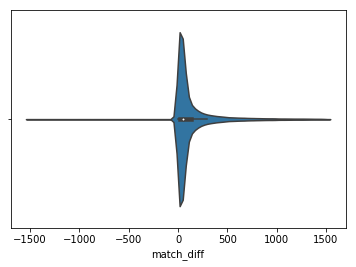

In [30]:
sns.violinplot(x='match_diff', data=gps_by_boarding_filtered[(gps_by_boarding_filtered['match_diff'] > -max_match_diff) & (gps_by_boarding_filtered['match_diff'] < max_match_diff)])

In [31]:
num_single_boardings = len(gps_by_boarding.drop_duplicates(subset=boarding_key_cols))
num_matched_boardings = len(gps_by_boarding_filtered)
num_missed_boardings = num_single_boardings - num_matched_boardings
perc_matched_boardings = num_matched_boardings/float(num_single_boardings)
perc_missed_boardings = num_missed_boardings/float(num_single_boardings)
print "single boardings: {}, matched boardings: {} ({}), missed boardings = {} ({})".format(num_single_boardings, num_matched_boardings, perc_matched_boardings, num_missed_boardings, perc_missed_boardings)

single boardings: 152743, matched boardings: 144607 (0.946734056553), missed boardings = 8136 (0.0532659434475)


In [32]:
all_boardings = gps_by_boarding[boarding_key_cols].drop_duplicates()
matched_boardings = gps_by_boarding_filtered[boarding_key_cols].drop_duplicates()
missed_boardings = pd.concat([all_boardings,matched_boardings]).drop_duplicates(keep=False)
print len(missed_boardings)
missed_boardings

8136


,cardNum,boarding_datetime
1057177,304627.0,2017-05-09 14:17:23
691455,305647.0,2017-05-09 17:08:47
266012,316234.0,2017-05-09 07:06:26
1091139,324934.0,2017-05-09 10:12:45
1091138,324934.0,2017-05-09 10:12:48
778632,328646.0,2017-05-09 17:25:45
176840,331502.0,2017-05-09 13:05:31
176841,331502.0,2017-05-09 13:05:33
1091260,334355.0,2017-05-09 06:16:23
303873,341560.0,2017-05-09 07:50:18


In [33]:
gps_by_boarding_missed = gps_by_boarding.merge(missed_boardings, on=boarding_key_cols, how='inner')
print len(gps_by_boarding_missed)

23227


In [34]:
gps_by_boarding_missed

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,304627.0,2017-05-09 14:17:23,2017-05-09 13:17:59,370,BC032,30158,3.0,1887,5511208,-25.446918,...,-49.295613,137.555310,13:17:59,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,3564.0
1,304627.0,2017-05-09 14:17:23,2017-05-09 07:40:20,370,BC032,30158,1.0,1887,5511208,-25.446918,...,NaN,NaN,07:40:20,BETWEEN,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,23823.0
2,304627.0,2017-05-09 14:17:23,2017-05-09 08:40:44,370,BC032,29938,2.0,1887,5511235,-25.442560,...,-49.288038,7.595160,08:40:44,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,20199.0
3,304627.0,2017-05-09 14:17:23,2017-05-09 08:21:38,370,BC032,28600,9.0,1887,5511336,-25.428420,...,-49.260450,196.955180,08:21:38,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,21345.0
4,304627.0,2017-05-09 14:17:23,2017-05-09 13:46:49,370,BC032,29938,13.0,1887,5511235,-25.442560,...,-49.288110,5.389940,13:46:49,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,1834.0
5,305647.0,2017-05-09 17:08:47,2017-05-09 14:37:05,170,BC297,36673,3.0,2747,5200673,-25.416165,...,NaN,NaN,14:37:05,BETWEEN,07/11/71,17:08:47,CABRAL / OSÓRIO,F,2017-05-09,9102.0
6,316234.0,2017-05-09 07:06:26,2017-05-09 12:44:19,777,JC008,26149,24.0,2195,4299860,-25.435179,...,-49.273396,9.121001,12:44:19,NO_PROBLEM,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-20273.0
7,316234.0,2017-05-09 07:06:26,2017-05-09 12:58:42,777,JC008,26583,15.0,2195,4299885,-25.439721,...,-49.269480,20.496515,12:58:42,TRIP_PROBLEM,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-21136.0
8,316234.0,2017-05-09 07:06:26,2017-05-09 12:59:49,777,JC008,32903,15.0,2195,4299895,-25.442293,...,NaN,NaN,12:59:49,BETWEEN,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-21203.0
9,324934.0,2017-05-09 10:12:45,2017-05-09 09:19:10,011,BB306,32770,2.0,3706,3920261,-25.446466,...,NaN,NaN,09:19:10,BETWEEN,23/04/81,10:12:45,INTERBAIRROS I A,F,2017-05-09,3215.0


#### Check the distribution of match_diff variable to evaluate the effectiveness of the threshold value

In [35]:
best_missed_boarding_matches = gps_by_boarding_missed.copy()
#best_missed_boarding_matches['match_diff'] = np.abs(best_missed_boarding_matches['match_diff'])
best_missed_boarding_matches = best_missed_boarding_matches.loc[best_missed_boarding_matches.groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
best_missed_boarding_matches = best_missed_boarding_matches[best_missed_boarding_matches['match_diff'] > 0]
best_missed_boarding_matches['match_diff'] = ((best_missed_boarding_matches['match_diff']-3600)/60)
best_missed_boarding_matches['match_diff'].describe()

count    5625.000000
mean       72.276403
std       172.810713
min       -34.983333
25%       -25.383333
50%        -1.983333
75%        67.433333
max       738.750000
Name: match_diff, dtype: float64

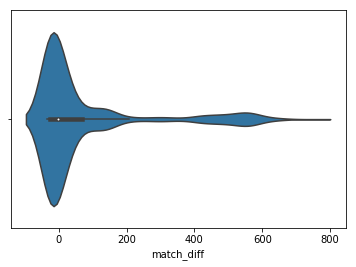

In [36]:
sns.violinplot(x="match_diff", data=best_missed_boarding_matches)

In [37]:
total_gps_data = len(gps_data)
gps_key_cols = ['route','busCode','tripNum','stopPointId']
gps_single_records = gps_data.dropna(subset=gps_key_cols).drop_duplicates(subset=gps_key_cols)
gps_with_no_boarding = gps_single_records[np.isnan(gps_single_records['cardNum'])]
num_single_gps_records = len(gps_single_records)
num_gps_no_boarding = len(gps_with_no_boarding)

print "total gps data: {}, num single GPS records: {}, num single GPS with no boarding: {} ({}), diff: {}" \
    .format(total_gps_data, num_single_gps_records, num_gps_no_boarding, 
            num_gps_no_boarding/float(num_single_gps_records), 
            num_single_gps_records - num_gps_no_boarding)

total gps data: 1298680, num single GPS records: 560992, num single GPS with no boarding: 484871 (0.864310007986), diff: 76121


#### Create GPS-boarding dataframe containing all unique GPS records and unique selected boarding records

In [38]:
missed_boarding_gps = gps_by_boarding_missed.copy()
missed_boarding_gps[['birthdate','cardTimestamp','lineName','cardNum','gender','boarding_datetime']] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

In [39]:
missed_boarding_gps

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaN,2017-05-09 13:17:59,370,BC032,30158,3.0,1887,5511208,-25.446918,...,-49.295613,137.555310,13:17:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,3564.0
1,NaN,NaN,2017-05-09 07:40:20,370,BC032,30158,1.0,1887,5511208,-25.446918,...,NaN,NaN,07:40:20,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,23823.0
2,NaN,NaN,2017-05-09 08:40:44,370,BC032,29938,2.0,1887,5511235,-25.442560,...,-49.288038,7.595160,08:40:44,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,20199.0
3,NaN,NaN,2017-05-09 08:21:38,370,BC032,28600,9.0,1887,5511336,-25.428420,...,-49.260450,196.955180,08:21:38,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,21345.0
4,NaN,NaN,2017-05-09 13:46:49,370,BC032,29938,13.0,1887,5511235,-25.442560,...,-49.288110,5.389940,13:46:49,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,1834.0
5,NaN,NaN,2017-05-09 14:37:05,170,BC297,36673,3.0,2747,5200673,-25.416165,...,NaN,NaN,14:37:05,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,9102.0
6,NaN,NaN,2017-05-09 12:44:19,777,JC008,26149,24.0,2195,4299860,-25.435179,...,-49.273396,9.121001,12:44:19,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-20273.0
7,NaN,NaN,2017-05-09 12:58:42,777,JC008,26583,15.0,2195,4299885,-25.439721,...,-49.269480,20.496515,12:58:42,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-21136.0
8,NaN,NaN,2017-05-09 12:59:49,777,JC008,32903,15.0,2195,4299895,-25.442293,...,NaN,NaN,12:59:49,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,-21203.0
9,NaN,NaN,2017-05-09 09:19:10,011,BB306,32770,2.0,3706,3920261,-25.446466,...,NaN,NaN,09:19:10,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,3215.0


In [40]:
print missed_boarding_gps.columns
print gps_with_no_boarding[cols_order].columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date'],
      dtype='object')


In [41]:
gps_with_no_boarding = gps_with_no_boarding[cols_order]
gps_with_no_boarding['match_diff'] = np.nan
gps_without_or_notselected_boarding = pd.concat([gps_with_no_boarding, missed_boarding_gps], axis=0) \
            .drop_duplicates(subset=gps_key_cols)
gps_without_or_notselected_boarding

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaT,2017-05-09 06:58:25,500,GE718,27560,2.0,4130,6464167,-25.433790,...,-49.270425,21.556105,06:58:25,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
1,NaN,NaT,2017-05-09 07:07:26,500,GE718,25471,4.0,4130,6464041,-25.459174,...,-49.258193,3.460972,07:07:26,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
2,NaN,NaT,2017-05-09 07:57:57,500,GE718,27551,5.0,4130,6463945,-25.481825,...,NaN,NaN,07:57:57,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
3,NaN,NaT,2017-05-09 08:00:09,500,GE718,27551,3.0,4130,6463945,-25.481825,...,-49.247050,12.410537,08:00:09,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
4,NaN,NaT,2017-05-09 08:10:07,500,GE718,27537,1.0,4130,6463793,-25.516848,...,-49.229840,23.004353,08:10:07,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
5,NaN,NaT,2017-05-09 06:53:44,500,GE718,25515,2.0,4130,6464140,-25.438837,...,-49.268180,12.105323,06:53:44,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
6,NaN,NaT,2017-05-09 07:18:04,500,GE718,27472,4.0,4130,6463875,-25.501550,...,NaN,NaN,07:18:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
7,NaN,NaT,2017-05-09 07:22:26,500,GE718,27537,5.0,4130,6463793,-25.516848,...,-49.229913,15.014615,07:22:26,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
8,NaN,NaT,2017-05-09 07:26:47,500,GE718,27472,1.0,4130,6463875,-25.501550,...,NaN,NaN,07:26:47,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
9,NaN,NaT,2017-05-09 07:28:04,500,GE718,27551,1.0,4130,6463945,-25.481825,...,NaN,NaN,07:28:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN


In [42]:
gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')

In [43]:
print "num unique GPS records not matched: {}".format(len(gps_without_or_notselected_boarding))

num unique GPS records not matched: 487799


In [44]:
print gps_by_boarding_filtered.columns
print gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')


In [45]:
boarding_gps_key_cols = boarding_key_cols + gps_key_cols
buste_fixed_result = pd.concat([gps_by_boarding_filtered, gps_without_or_notselected_boarding]) \
                        .drop_duplicates(subset=boarding_gps_key_cols) \
                        .reset_index(drop=True)
buste_fixed_result

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0
1,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0
2,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
3,304127.0,2017-05-09 10:24:50,2017-05-09 10:23:32,175,BC010,31749,11.0,2743,5404834,-25.451146,...,-49.252913,39.855495,10:23:32,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,78.0
4,304127.0,2017-05-09 10:57:36,2017-05-09 10:57:08,370,LC016,25428,8.0,3669,6592082,-25.436333,...,NaN,NaN,10:57:08,BETWEEN,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,28.0
5,304627.0,2017-05-09 16:24:40,2017-05-09 16:05:27,370,LC020,30157,6.0,3669,6592013,-25.444290,...,-49.291258,5.801413,16:05:27,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017-05-09,1153.0
6,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,6.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,TRIP_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
7,306573.0,2017-05-09 07:50:41,2017-05-09 07:48:58,323,DA033,32543,18.0,1861,5583329,-25.450101,...,-49.206238,5.976702,07:48:58,NO_PROBLEM,03/04/59,07:50:41,MAD. CENTENÁRIO,F,2017-05-09,103.0
8,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:39,468,DC090,31505,3.0,1926,4418075,-25.467945,...,NaN,NaN,17:55:39,BETWEEN,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,9.0
9,312500.0,2017-05-09 13:26:11,2017-05-09 13:24:20,175,BC282,26374,3.0,1743,5444416,-25.433387,...,-49.270966,122.456345,13:24:20,NO_PROBLEM,26/02/82,13:26:11,BOM RETIRO / PUC,F,2017-05-09,111.0


### Match BUSTE GPS entries with their respective parent stop codes

#### Read GTFS stops file

In [46]:
stops_df = pd.read_csv('/local/tarciso/data/gtfs/curitiba/stops.txt')

In [47]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,70,104505,Terminal Campina do Siqueira - 303 - Centenári...,Terminal Campina do Siqueira - Campo Comprido,-25.435724,-49.306998,NaN,NaN,0,14506.0,NaN,NaN
1,270,104905,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501341,-49.237597,NaN,NaN,0,14485.0,NaN,NaN
2,276,105606,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451550,-49.214917,NaN,NaN,0,14481.0,NaN,NaN
3,299,105603,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451665,-49.215086,NaN,NaN,0,14481.0,NaN,NaN
4,308,104907,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501311,-49.237825,NaN,NaN,0,14485.0,NaN,NaN


In [48]:
stops_parent_stations = stops_df[['stop_id','parent_station']]

#### Add parent station ID to GPS Boardings data

In [49]:
gps_stops_with_parent_stations = buste_fixed_result.merge(stops_parent_stations, left_on='stopPointId', right_on='stop_id', how='left')

In [50]:
gps_stops_with_parent_stations.head()

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff,stop_id,parent_station
0,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0,35349.0,NaN
1,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0,31195.0,NaN
2,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0,36094.0,NaN
3,304127.0,2017-05-09 10:24:50,2017-05-09 10:23:32,175,BC010,31749,11.0,2743,5404834,-25.451146,...,10:23:32,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,78.0,31749.0,NaN
4,304127.0,2017-05-09 10:57:36,2017-05-09 10:57:08,370,LC016,25428,8.0,3669,6592082,-25.436333,...,10:57:08,BETWEEN,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,28.0,25428.0,NaN


In [51]:
num_records_with_parent_station = len(gps_stops_with_parent_stations[np.logical_not(np.isnan(gps_stops_with_parent_stations['parent_station']))])
total_num_gps_records = len(gps_stops_with_parent_stations)
print "Num stops with parent station: {} ({})".format(num_records_with_parent_station, num_records_with_parent_station/float(total_num_gps_records))
print "Num stop GPS records: {}".format(len(gps_stops_with_parent_stations))

Num stops with parent station: 74229 (0.117375546722)
Num stop GPS records: 632406


#### Concatenate line 000 boardings with GPS boardings

In [52]:
matched_000_stations.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
81916,000,OPER S/LINHA,03036,3103755,07:06:52,09/05/17,14/01/96,F,2017-05-09 07:06:52,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81915,000,OPER S/LINHA,03036,3476595,15:54:33,09/05/17,27/11/92,M,2017-05-09 15:54:33,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81914,000,OPER S/LINHA,03036,3772075,18:08:20,09/05/17,27/10/84,F,2017-05-09 18:08:20,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81913,000,OPER S/LINHA,03036,3483992,16:16:02,09/05/17,26/08/90,M,2017-05-09 16:16:02,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777


In [53]:
line_000_boardings = matched_000_stations.drop(['LINE','NAME','URBS_CODE','LAT','LON','boarding_datetime','DATAUTILIZACAO'], axis=1) \
                        .rename(index=str, columns={'CODLINHA': 'route', 'CODVEICULO': 'busCode', 
                                                    'DATANASCIMENTO':'birthdate','HORAUTILIZACAO':'cardTimestamp',
                                                    'NOMELINHA':'lineName','NUMEROCARTAO':'cardNum',
                                                     'SEXO':'gender','STOP_ID':'stopPointId'})

In [54]:
line_000_boardings.head()

,route,lineName,busCode,cardNum,cardTimestamp,birthdate,gender,stopPointId
0,000,OPER S/LINHA,00070,1353891,11:05:57,22/11/58,M,14487
81916,000,OPER S/LINHA,03036,3103755,07:06:52,14/01/96,F,26105
81915,000,OPER S/LINHA,03036,3476595,15:54:33,27/11/92,M,26105
81914,000,OPER S/LINHA,03036,3772075,18:08:20,27/10/84,F,26105
81913,000,OPER S/LINHA,03036,3483992,16:16:02,26/08/90,M,26105


In [55]:
print "Num line 000 boarding with stations: {}".format(len(line_000_boardings))

Num line 000 boarding with stations: 122864


In [56]:
gps_stops_with_parent_stations.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff', u'stop_id', u'parent_station'],
      dtype='object')

In [57]:
print "Num GPS stops with parent stations: {}".format(len(gps_stops_with_parent_stations))

Num GPS stops with parent stations: 632406


In [58]:
gps_boardings_with_000 = pd.concat([gps_stops_with_parent_stations,line_000_boardings]) \
                            .drop('stop_id', axis=1)

In [59]:
gps_boardings_with_000 = gps_boardings_with_000[['route','busCode','tripNum','stopPointId','parent_station','cardNum','cardTimestamp','gps_datetime',
                                      'shapeId','shapeSequence','shapeLat','shapeLon','distanceTraveledShape','gpsPointId',
                                      'gpsLat','gpsLon','distanceToShapePoint','timestamp','problem','lineName','birthdate',
                                      'lineName','gender','date']] \
                            .sort_values(['cardNum','cardTimestamp'])

In [60]:
gps_boardings_with_000

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
0,654,HA017,1.0,35349,NaN,229948.0,06:29:09,2017-05-09 06:28:51,2106.0,6040781.0,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
1,511,EA172,22.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:48:14,2746.0,5846156.0,...,NaN,NaN,NaN,07:48:14,BETWEEN,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
2,654,HA240,2.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
3,175,BC010,11.0,31749,NaN,304127.0,10:24:50,2017-05-09 10:23:32,2743.0,5404834.0,...,-25.450788,-49.252913,39.855495,10:23:32,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,8.0,25428,NaN,304127.0,10:57:36,2017-05-09 10:57:08,3669.0,6592082.0,...,NaN,NaN,NaN,10:57:08,BETWEEN,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09


In [61]:
buste_final_result = gps_boardings_with_000.copy()
size_buste_final_result = len(buste_final_result)

In [62]:
selected_gps_and_boarding_matches = buste_final_result[pd.notnull(buste_final_result.cardNum) & pd.notnull(buste_final_result.gps_datetime)]
num_selected_gps_and_boarding_matches = len(selected_gps_and_boarding_matches)

print "Number of GPS and Boarding matches: {} ({})".format(num_selected_gps_and_boarding_matches,num_selected_gps_and_boarding_matches/(float(size_buste_final_result)))
selected_gps_and_boarding_matches.head(10)

Number of GPS and Boarding matches: 144607 (0.191463979769)


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
0,654,HA017,1.0,35349,NaN,229948.0,06:29:09,2017-05-09 06:28:51,2106.0,6040781.0,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
1,511,EA172,22.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:48:14,2746.0,5846156.0,...,NaN,NaN,NaN,07:48:14,BETWEEN,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
2,654,HA240,2.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
3,175,BC010,11.0,31749,NaN,304127.0,10:24:50,2017-05-09 10:23:32,2743.0,5404834.0,...,-25.450788,-49.252913,39.855495,10:23:32,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,8.0,25428,NaN,304127.0,10:57:36,2017-05-09 10:57:08,3669.0,6592082.0,...,NaN,NaN,NaN,10:57:08,BETWEEN,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09
5,370,LC020,6.0,30157,NaN,304627.0,16:24:40,2017-05-09 16:05:27,3669.0,6592013.0,...,-25.444276,-49.291258,5.801413,16:05:27,NO_PROBLEM,RUA XV / BARIGUI,05/04/53,RUA XV / BARIGUI,F,2017-05-09
6,777,JC004,6.0,32097,NaN,306135.0,07:56:49,2017-05-09 07:56:48,2194.0,4299781.0,...,-25.446305,-49.275308,32.238018,07:56:48,TRIP_PROBLEM,V. VELHA,29/10/52,V. VELHA,M,2017-05-09
7,323,DA033,18.0,32543,NaN,306573.0,07:50:41,2017-05-09 07:48:58,1861.0,5583329.0,...,-25.450051,-49.206238,5.976702,07:48:58,NO_PROBLEM,MAD. CENTENÁRIO,03/04/59,MAD. CENTENÁRIO,F,2017-05-09
8,468,DC090,3.0,31505,NaN,310241.0,17:55:48,2017-05-09 17:55:39,1926.0,4418075.0,...,NaN,NaN,NaN,17:55:39,BETWEEN,JD. ITIBERÊ,13/01/72,JD. ITIBERÊ,M,2017-05-09
9,175,BC282,3.0,26374,NaN,312500.0,13:26:11,2017-05-09 13:24:20,1743.0,5444416.0,...,-25.432641,-49.270966,122.456345,13:24:20,NO_PROBLEM,BOM RETIRO / PUC,26/02/82,BOM RETIRO / PUC,F,2017-05-09


In [63]:
gps_without_boarding = buste_final_result[pd.isnull(buste_final_result.cardNum) & pd.notnull(buste_final_result.gps_datetime)]
num_gps_without_boarding = len(gps_without_boarding)

print "Number of GPS records without boarding: {} ({})".format(num_gps_without_boarding,num_gps_without_boarding/(float(size_buste_final_result)))
gps_without_boarding.head(10)

Number of GPS records without boarding: 487799 (0.645860420777)


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
144607,500,GE718,2.0,27560,43723.0,NaN,NaN,2017-05-09 06:58:25,4130.0,6464167.0,...,-25.433916,-49.270425,21.556105,06:58:25,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144608,500,GE718,4.0,25471,43353.0,NaN,NaN,2017-05-09 07:07:26,4130.0,6464041.0,...,-25.459181,-49.258193,3.460972,07:07:26,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144609,500,GE718,5.0,27551,14487.0,NaN,NaN,2017-05-09 07:57:57,4130.0,6463945.0,...,NaN,NaN,NaN,07:57:57,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
144610,500,GE718,3.0,27551,14487.0,NaN,NaN,2017-05-09 08:00:09,4130.0,6463945.0,...,-25.481915,-49.247050,12.410537,08:00:09,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144611,500,GE718,1.0,27537,14489.0,NaN,NaN,2017-05-09 08:10:07,4130.0,6463793.0,...,-25.516915,-49.229840,23.004353,08:10:07,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144612,500,GE718,2.0,25515,NaN,NaN,NaN,2017-05-09 06:53:44,4130.0,6464140.0,...,-25.438738,-49.268180,12.105323,06:53:44,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144613,500,GE718,4.0,27472,14485.0,NaN,NaN,2017-05-09 07:18:04,4130.0,6463875.0,...,NaN,NaN,NaN,07:18:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
144614,500,GE718,5.0,27537,14489.0,NaN,NaN,2017-05-09 07:22:26,4130.0,6463793.0,...,-25.516885,-49.229913,15.014615,07:22:26,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09
144615,500,GE718,1.0,27472,14485.0,NaN,NaN,2017-05-09 07:26:47,4130.0,6463875.0,...,NaN,NaN,NaN,07:26:47,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09
144616,500,GE718,1.0,27551,14487.0,NaN,NaN,2017-05-09 07:28:04,4130.0,6463945.0,...,NaN,NaN,NaN,07:28:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09


In [64]:
boarding_without_gps = buste_final_result[pd.notnull(buste_final_result.cardNum) & pd.isnull(buste_final_result.gps_datetime)]
num_boarding_without_gps = len(boarding_without_gps)

print "Number of boarding records with no matched GPS: {} ({})".format(num_boarding_without_gps,num_boarding_without_gps/(float(size_buste_final_result)))
print "Percentage of boarding records to be matched to GPS: {}".format(num_boarding_without_gps/(float(num_boarding_without_gps + num_selected_gps_and_boarding_matches)))
boarding_without_gps.head(10)

Number of boarding records with no matched GPS: 122864 (0.162675599454)
Percentage of boarding records to be matched to GPS: 0.459354472074


,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
111178,000,09021,NaN,26112,NaN,304148.0,17:57:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/05/72,OPER S/LINHA,F,NaT
120416,000,05007,NaN,14517,NaN,305601.0,11:06:44,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
53052,000,00045,NaN,43723,NaN,305601.0,13:32:37,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,25/04/78,OPER S/LINHA,M,NaT
121786,000,06047,NaN,26057,NaN,306504.0,08:18:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,02/03/59,OPER S/LINHA,F,NaT
108774,000,05006,NaN,14471,NaN,307365.0,17:46:57,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,09/01/81,OPER S/LINHA,M,NaT


In [65]:
buste_final_result.head(20)

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,lineName,birthdate,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,07:01:00,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,27/04/94,OPER S/LINHA,F,NaT
0,654,HA017,1.0,35349,NaN,229948.0,06:29:09,2017-05-09 06:28:51,2106.0,6040781.0,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,06:39:21,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,20/09/96,OPER S/LINHA,F,NaT
1,511,EA172,22.0,31195,NaN,257342.0,07:48:58,2017-05-09 07:48:14,2746.0,5846156.0,...,NaN,NaN,NaN,07:48:14,BETWEEN,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,F,2017-05-09
113863,000,01021,NaN,26037,NaN,257342.0,17:24:51,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,24/01/71,OPER S/LINHA,F,NaT
41369,000,03047,NaN,14553,NaN,272904.0,17:24:52,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,17/09/74,OPER S/LINHA,F,NaT
2,654,HA240,2.0,36094,NaN,300327.0,06:56:45,2017-05-09 06:55:54,2106.0,6040871.0,...,-25.501313,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,OP. CONTIGENCIA,20/05/59,OP. CONTIGENCIA,F,2017-05-09
27672,000,00038,NaN,26051,NaN,303661.0,17:43:10,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,OPER S/LINHA,23/06/73,OPER S/LINHA,M,NaT
3,175,BC010,11.0,31749,NaN,304127.0,10:24:50,2017-05-09 10:23:32,2743.0,5404834.0,...,-25.450788,-49.252913,39.855495,10:23:32,NO_PROBLEM,BOM RETIRO / PUC,09/06/54,BOM RETIRO / PUC,M,2017-05-09
4,370,LC016,8.0,25428,NaN,304127.0,10:57:36,2017-05-09 10:57:08,3669.0,6592082.0,...,NaN,NaN,NaN,10:57:08,BETWEEN,RUA XV / BARIGUI,09/06/54,RUA XV / BARIGUI,M,2017-05-09


#### Write BUSTE final result to file

In [69]:
buste_final_result.to_csv('/local/tarciso/masters/data/bus_trips/test/buste-05-09-2017.csv', index=False)

#### Analyze distribution of number of trips per user on a single day

In [100]:
trips_per_user = buste_final_result.groupby(['cardNum']).cardNum.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True) \
                    .reset_index(name='num_trips', level=0)

In [101]:
trips_per_user

,index,num_trips
0,1,0.579600
1,2,0.323773
2,3,0.066577
3,4,0.023262
4,5,0.003787
5,6,0.002231
6,7,0.000379
7,8,0.000251
8,9,0.000087
9,10,0.000047


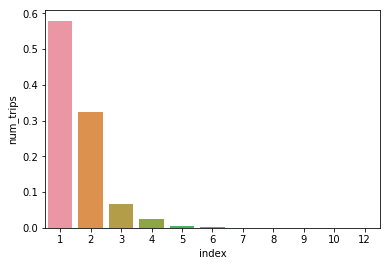

In [102]:
#sns.distplot(trips_per_user, hist=True)
#sns.violinplot(trips_per_user)
sns.barplot(x='index', y='num_trips', data=trips_per_user)

#### Compare with distribution of number of trips per user on a day on the original ticketing data

In [103]:
boarding_data.columns

Index([u'CODLINHA', u'NOMELINHA', u'CODVEICULO', u'NUMEROCARTAO',
       u'HORAUTILIZACAO', u'DATAUTILIZACAO', u'DATANASCIMENTO', u'SEXO',
       u'boarding_datetime'],
      dtype='object')

In [104]:
trips_per_user_original = boarding_data.groupby('NUMEROCARTAO').NUMEROCARTAO.count().reset_index(name='num_trips').num_trips.value_counts(normalize=True).reset_index(name='num_trips')

In [105]:
trips_per_user_original

,index,num_trips
0,1,0.500482
1,2,0.382923
2,3,0.078011
3,4,0.029663
4,5,0.004827
5,6,0.002977
6,7,0.000495
7,8,0.000396
8,9,0.000130
9,10,0.000094


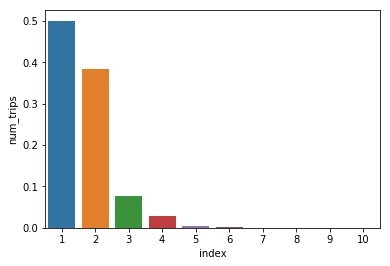

In [106]:
sns.barplot(x='index', y='num_trips', data=trips_per_user_original)

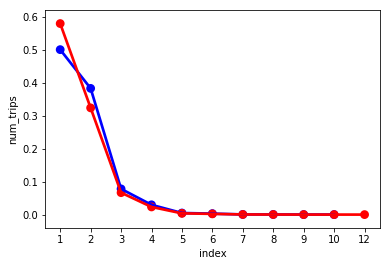

In [131]:
fig, ax = plt.subplots()
sns.pointplot(x='index', y='num_trips', data=trips_per_user_original, ax=ax, color='blue')
sns.pointplot(x='index', y='num_trips', data=trips_per_user, ax=ax, color='red')

#### Finding buses for the following boarding entry:

In [70]:
matched_000_stations[:1]

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.4819,-49.247078


In [71]:
type(gps_stops_with_parent_stations['stopPointId'][0])

numpy.int64

#### Select candidate bus/trip records by filtering the ones which did not go throught the boarding station

In [72]:
candidate_bus_trips = gps_stops_with_parent_stations.query('parent_station==14492') \
                        .drop_duplicates(subset=['route','busCode','tripNum']) \
                        .sort_values(by='gps_datetime')

In [73]:
candidate_bus_trips

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff,stop_id,parent_station
476308,NaN,NaT,2017-05-09 04:54:15,547,GA146,30013,21.0,1994,6165177,-25.534173,...,04:54:15,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30013.0,14492.0
42016,2462475.0,2017-05-09 04:59:22,2017-05-09 04:58:58,542,GA124,30012,13.0,1988,6404092,-25.534141,...,04:58:58,NO_PROBLEM,08/06/85,04:59:22,BAIRRO NOVO B,F,2017-05-09,24.0,30012.0,14492.0
454977,NaN,NaT,2017-05-09 05:01:29,548,GA205,4661,20.0,3581,6568518,-25.534214,...,05:01:29,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,4661.0,14492.0
228977,NaN,NaT,2017-05-09 05:03:59,542,GA124,30012,14.0,1988,6404092,-25.534141,...,05:03:59,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30012.0,14492.0
65950,3090669.0,2017-05-09 05:08:22,2017-05-09 05:07:50,547,GA146,30013,22.0,1994,6165177,-25.534173,...,05:07:50,NO_PROBLEM,12/03/85,05:08:22,BAIRRO NOVO C,F,2017-05-09,32.0,30013.0,14492.0
420560,NaN,NaT,2017-05-09 05:15:17,502,GR028,27079,1.0,3241,6256532,-25.534277,...,05:15:17,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,27079.0,14492.0
450103,NaN,NaT,2017-05-09 05:15:31,548,GA204,4661,3.0,3580,5955066,-25.534213,...,05:15:31,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,4661.0,14492.0
39462,2394563.0,2017-05-09 05:19:36,2017-05-09 05:18:56,540,GR409,5346,1.0,1985,6328328,-25.534398,...,05:18:56,BETWEEN,01/05/80,05:19:36,OP. CONTIGENCIA,F,2017-05-09,40.0,5346.0,14492.0
476335,NaN,NaT,2017-05-09 05:24:11,547,GA146,30013,30.0,1994,6165177,-25.534173,...,05:24:11,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30013.0,14492.0
239058,NaN,NaT,2017-05-09 05:27:18,625,GA162,30020,4.0,2051,6451371,-25.534497,...,05:27:18,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30020.0,14492.0


In [74]:
candidate_bus_trips['diff_boarding_arrival'] = np.abs(candidate_bus_trips['gps_datetime'] - pd.to_datetime('2017-05-09 04:47:52', format='%Y-%m-%d %H:%M:%S'))
candidate_bus_trips = candidate_bus_trips[candidate_bus_trips['diff_boarding_arrival'] < pd.Timedelta('1 hour')]

In [75]:
candidate_bus_trips.head(10)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff,stop_id,parent_station,diff_boarding_arrival
476308,NaN,NaT,2017-05-09 04:54:15,547,GA146,30013,21.0,1994,6165177,-25.534173,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30013.0,14492.0,00:06:23
42016,2462475.0,2017-05-09 04:59:22,2017-05-09 04:58:58,542,GA124,30012,13.0,1988,6404092,-25.534141,...,NO_PROBLEM,08/06/85,04:59:22,BAIRRO NOVO B,F,2017-05-09,24.0,30012.0,14492.0,00:11:06
454977,NaN,NaT,2017-05-09 05:01:29,548,GA205,4661,20.0,3581,6568518,-25.534214,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,4661.0,14492.0,00:13:37
228977,NaN,NaT,2017-05-09 05:03:59,542,GA124,30012,14.0,1988,6404092,-25.534141,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30012.0,14492.0,00:16:07
65950,3090669.0,2017-05-09 05:08:22,2017-05-09 05:07:50,547,GA146,30013,22.0,1994,6165177,-25.534173,...,NO_PROBLEM,12/03/85,05:08:22,BAIRRO NOVO C,F,2017-05-09,32.0,30013.0,14492.0,00:19:58
420560,NaN,NaT,2017-05-09 05:15:17,502,GR028,27079,1.0,3241,6256532,-25.534277,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,27079.0,14492.0,00:27:25
450103,NaN,NaT,2017-05-09 05:15:31,548,GA204,4661,3.0,3580,5955066,-25.534213,...,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,4661.0,14492.0,00:27:39
39462,2394563.0,2017-05-09 05:19:36,2017-05-09 05:18:56,540,GR409,5346,1.0,1985,6328328,-25.534398,...,BETWEEN,01/05/80,05:19:36,OP. CONTIGENCIA,F,2017-05-09,40.0,5346.0,14492.0,00:31:04
476335,NaN,NaT,2017-05-09 05:24:11,547,GA146,30013,30.0,1994,6165177,-25.534173,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30013.0,14492.0,00:36:19
239058,NaN,NaT,2017-05-09 05:27:18,625,GA162,30020,4.0,2051,6451371,-25.534497,...,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,30020.0,14492.0,00:39:26


In [76]:
def get_arrival_time_at_next_stop_after_station(gps_df,route,vehicle,trip,station_timestamp):
        return gps_df[((gps_df['route'] == route) & (gps_df['busCode'] == vehicle)) \
                      & ((gps_df['tripNum'] == trip) & (gps_df['gps_datetime'] > station_timestamp))] \
                .drop_duplicates(subset=['route','busCode','tripNum','stopPointId']) \
                .sort_values('gps_datetime')
    

In [77]:
get_arrival_time_at_next_stop_after_station(gps_stops_with_parent_stations,'542','GA124',13,pd.to_datetime('2017-05-09 04:47:52', format='%Y-%m-%d %H:%M:%S'))

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff,stop_id,parent_station
36479,2340643.0,2017-05-09 04:48:53,2017-05-09 04:48:22,542,GA124,31255,13.0,1988,6403957,-25.551388,...,04:48:22,NO_PROBLEM,07/11/63,04:48:53,BAIRRO NOVO B,M,2017-05-09,31.0,31255.0,NaN
2160,785212.0,2017-05-09 04:49:15,2017-05-09 04:48:59,542,GA124,31256,13.0,1988,6403964,-25.550431,...,04:48:59,NO_PROBLEM,19/02/80,04:49:15,BAIRRO NOVO B,F,2017-05-09,16.0,31256.0,NaN
3788,931864.0,2017-05-09 04:50:49,2017-05-09 04:49:55,542,GA124,31257,13.0,1988,6403971,-25.551567,...,04:49:55,NO_PROBLEM,15/08/63,04:50:49,BAIRRO NOVO B,F,2017-05-09,54.0,31257.0,NaN
228972,NaN,NaT,2017-05-09 04:51:05,542,GA124,31258,13.0,1988,6403979,-25.550383,...,04:51:05,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,31258.0,NaN
139463,3824438.0,2017-05-09 04:51:57,2017-05-09 04:51:40,542,GA124,31259,13.0,1988,6403984,-25.549763,...,04:51:40,NO_PROBLEM,12/04/94,04:51:57,BAIRRO NOVO B,F,2017-05-09,17.0,31259.0,NaN
5988,1119175.0,2017-05-09 04:53:27,2017-05-09 04:52:48,542,GA124,31260,13.0,1988,6403992,-25.547981,...,04:52:48,NO_PROBLEM,17/04/62,04:53:27,BAIRRO NOVO B,F,2017-05-09,39.0,31260.0,NaN
228973,NaN,NaT,2017-05-09 04:53:41,542,GA124,31261,13.0,1988,6404006,-25.545885,...,04:53:41,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN,31261.0,NaN
5983,1118881.0,2017-05-09 04:55:11,2017-05-09 04:54:19,542,GA124,31262,13.0,1988,6404013,-25.545020,...,04:54:19,NO_PROBLEM,05/01/84,04:55:11,BAIRRO NOVO B,F,2017-05-09,52.0,31262.0,NaN
130047,3788948.0,2017-05-09 04:55:22,2017-05-09 04:55:19,542,GA124,31250,13.0,1988,6404027,-25.543177,...,04:55:19,NO_PROBLEM,07/07/78,04:55:22,BAIRRO NOVO B,M,2017-05-09,3.0,31250.0,NaN
9342,1342841.0,2017-05-09 04:56:09,2017-05-09 04:56:00,542,GA124,31263,13.0,1988,6404044,-25.541586,...,04:56:00,BETWEEN,13/08/59,04:56:09,BAIRRO NOVO B,F,2017-05-09,9.0,31263.0,NaN


In [78]:
gps_stops[gps_stops['stopPointId'] == 14487]

NameError: name 'gps_stops' is not defined

In [ ]:
gps_stops.merge(line_000_terminals, left_on='stopPointId', right_on='STOP_ID', how='inner')